In [1]:
import imp
import keras.backend
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import os

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.optimizers import RMSprop

import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.tests.networks.base
import innvestigate.utils.visualizations as ivis

from innvestigate.tools import Perturbation, PerturbationAnalysis

base_dir = ".."
eutils = imp.load_source("utils", os.path.join(base_dir, "utils.py"))

keras.backend.set_image_data_format("channels_first")

Using TensorFlow backend.


In [2]:
# Define helper functions
def fetch_data():
    # the data, shuffled and split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(60000, 1, 28, 28)
    x_test = x_test.reshape(10000, 1, 28, 28)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    return x_train, y_train, x_test, y_test


def create_model():
    num_classes = 10

    network = innvestigate.utils.tests.networks.base.mlp_2dense(
        (None, 1, 28, 28),
        num_classes,
        dense_units=1024,
        dropout_rate=0.25)
    model_wo_sm = Model(inputs=network["in"], outputs=network["out"])
    model_w_sm = Model(inputs=network["in"], outputs=network["sm_out"])
    return model_wo_sm, model_w_sm


def train_model(model, data):
    batch_size = 128
    num_classes = 10
    epochs = 5

    x_train, y_train, x_test, y_test = data
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

def preprocess(X, zero_mean=False):
    X.copy()
    X /= 255.0
    if zero_mean:
        X -= 0.5
    return X

In [3]:
# Load data
num_classes = 10
batch_size = 256
data = fetch_data()
data_preprocessed = (preprocess(data[0]), data[1],
                         preprocess(data[2]), data[3])
x_test, y_test = data_preprocessed[2:]
y_test = keras.utils.to_categorical(y_test, num_classes)
generator = iutils.BatchSequence([x_test, y_test], batch_size=batch_size)
test_sample = np.copy(generator[0][0][0:1])

60000 train samples
10000 test samples


In [4]:
# Build and train the model
model_without_softmax, model_with_softmax = create_model()
train_model(model_with_softmax, data_preprocessed)
model_without_softmax.set_weights(model_with_softmax.get_weights())

Epoch 1/5
60000/60000 [==============================] - 19s 316us/step - loss: 0.2485 - acc: 0.9253
Epoch 2/5
60000/60000 [==============================] - 18s 300us/step - loss: 0.1033 - acc: 0.9692
Epoch 3/5
60000/60000 [==============================] - 18s 304us/step - loss: 0.0726 - acc: 0.9781
Epoch 4/5
60000/60000 [==============================] - 21s 358us/step - loss: 0.0572 - acc: 0.9827
Epoch 5/5
60000/60000 [==============================] - 20s 339us/step - loss: 0.0454 - acc: 0.9862
Test loss: 0.08342568186619319
Test accuracy: 0.9762


# Perturbation Analysis

In [5]:
# Setup analyzer
perturbation_function = "gaussian"
region_shape  = (7, 7)
ratio = 0.2
steps = 5
method = ("lrp.z_baseline", {}, ivis.heatmap, "LRP-Z")

analyzer = innvestigate.create_analyzer(method[0],
                                        model_without_softmax,
                                        **method[1])

In [6]:
# Setup perturbation
perturbation = Perturbation(perturbation_function, region_shape=region_shape)
perturbation_analysis = PerturbationAnalysis(analyzer, model_with_softmax, generator, perturbation,
                                                 steps=steps, ratio=ratio)

## 1. Evaluate the model after perturbation of the input

In [7]:
scores = perturbation_analysis.compute_perturbation_analysis()

Scores:
[[0.08342568 0.9762    ]
 [0.14826956 0.9562    ]
 [0.29079764 0.921     ]
 [0.49998943 0.8782    ]
 [0.87957282 0.8164    ]
 [1.42801931 0.7434    ]]


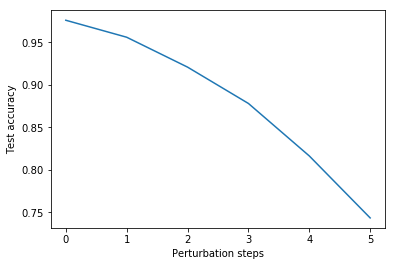

In [8]:
scores = np.array(scores)
print("Scores:")
print(scores)
plt.plot(scores[:, 1])
plt.xlabel("Perturbation steps")
plt.ylabel("Test accuracy")
plt.xticks(np.array(range(scores.shape[0])))
plt.show()

## 2. Plot perturbed sample

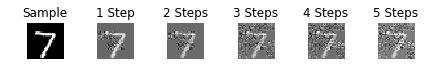

In [9]:
steps = 5

plt.figure()
plt.subplot(1, steps + 1, 1)
plt.imshow(np.squeeze(test_sample), cmap="Greys_r")
plt.axis("off")
plt.title("Sample")

for i in range(steps):
    test_sample = perturbation_analysis.compute_on_batch(test_sample)
    plt.subplot(1, steps + 1, i + 2)
    plt.imshow(np.squeeze(test_sample), cmap="Greys_r")
    plt.title("{} Step{}".format(i + 1, "" if i == 0 else "s"))
    plt.axis("off")
plt.tight_layout()  # Takes care of spaces between subfigures
plt.show()